Here are all the module imports and global settings (such as plot styles and warning levels) for the whole notebook.

In [1]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc

import copy
import math
import gensim
import json
import os
import sklearn
import torch
import warnings

from functools import partial
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from graphviz import Digraph
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from IPython.display import Image
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotly.offline import plot
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from time import time
from utils import make_meshgrid

pylab.rcParams['figure.figsize'] = 5, 5

plt.rc("font", size=15)

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

warnings.filterwarnings("ignore")

/scicore/home/lauerg/cerque0000/.conda/envs/DNN_CUDA10/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Table Of Contents:

* [**Raw sequences data set**](#raw_sequences)
* [**One-hot encoding**](#one_hot)
* [**Word2Vec**](#word2vec)
* [**Doc2Vec**](#doc2vec)
* [**Trying homemade features**](#homemade_features)
* [**Bringing homemade and Doc2Vec together**](#homemade_and_doc2vec)
* [**Convolutional layers**](#conv_layers)

# Raw sequences data set (you will not have access to those data)<a class="anchor" id="raw_sequences"></a>

In [2]:
data_path = 'Datasets/Mihaela/'

# Read file
r = open(os.path.join(data_path, 'yeast_decay')).read()

# Get lines
lines = r.splitlines()

# Split lines into columns by tab marker
lines_split = [line.split('\t') for line in lines[1:]]

# Save table data as a pandas.DataFrame
df = pd.DataFrame(lines_split, columns=lines[0].split('\t'))
df.head()

,ID,ORF length,5UTR,ORF,3UTR,Cramer
0,YAL054C,2142,AAGCAAAACCAAACATATCAAAACTACTAGAAAGACATTGCCCACT...,ATGTCGCCCTCTGCCGTACAATCATCAAAACTAGAAGAACAGTCAA...,GATGATTTCTTTCCTTTTTATATTGACGACTTTTTTTTTTTCGTGT...,19.50718579
1,YAL049C,741,AAGACTCAGTAGACTTAAAGTTTTCCACTACGTCTAACTACAGCAG...,ATGGCATCTAATCAACCTGGCAAGTGTTGCTTTGAAGGAGTTTGTC...,AGGGAAGAGCTCTTCTTACGTTAACCGTTATATACATATATATATA...,24.22162446
2,YAL047C,1869,AAGCAAACAACATAAGGAAAGTTATAGCC,ATGGTACGTCGATGGATTCCTAGTGGCAGGCATCTTCGCAATAATG...,TATCATACGTTTATATATAAATATATTTAATGTAACACTCAGTCAC...,8.35509907
3,YAL046C,357,AAAAGCGAAAAGAGAAGGTAAAACATAGAA,ATGAAGCTCCCACAGACCATGCTACGTTCTATATCTGTGAAGCATG...,CAGTTTGGAACCAAAAAAGCTCGTGTAAGTATCACTTTTAGTTTAC...,22.10929488
4,YAL044C,513,ACATCGACA,ATGTTACGCACTACTAGACTATGGACCACCCGCATGCCCACTGTGA...,CAAAGCTTATACGTACGTAAAGTAATTTCATATATATGTATATATA...,128.0398455


In [3]:
dico_cramer_to_length = {u:v for v, u in zip(list(df['ORF length'].astype('float32')), list(df.Cramer.astype('float32')))}

print(len(dico_cramer_to_length), df.shape)

4222 (4222, 6)


Using the dataset above, we would like to be able to predict the decay rate of transcripts from their sequences. But we cannot feed the raw sequences to any neural net the way they are. We need to represent them with numbers somehow.

Let's explore some possibilities here :

- **One-hot encoding**
- **Domain expertise vector profile**
- **Neural Net for representation**

We have already seen the use of *Domain expertise vector profile* in the subcellular localization example in the [introductory notebook](1_Introduction_to_deep_learning.ipynb).

# One-hot encoding <a class="anchor" id="one_hot"></a>

Our approach here will be to code every site in the sequences with a vector of dimension 4 (for the 4 nucleotides).

- A: `[1, 0, 0, 0]`
- T: `[0, 1, 0, 0]`
- G: `[0, 0, 1, 0]`
- C: `[0, 0, 0, 1]`

In doing so we are going to increase the sequence size 4-fold, which may be problematic later on in termm of the size of our neural network. But let's give it a try any way.

Regardless, before even doing the one-hot encoding we have to decide on which sequences to tackle ("ORF", "5UTR", or "3UTR"), and which part of those sequences we take.


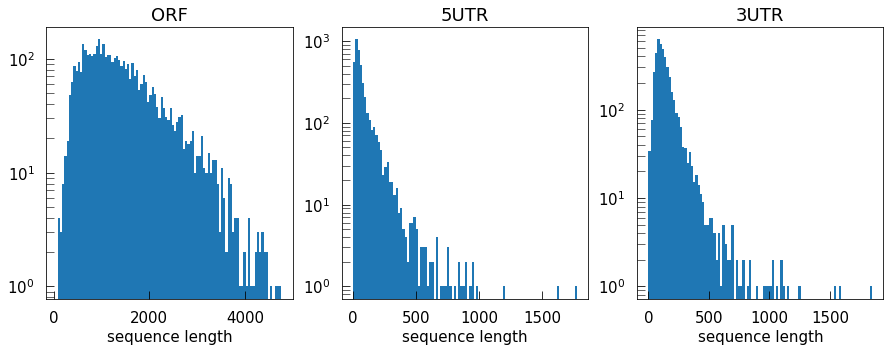

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist([len(v) for v in list(df.ORF)], 100)
ax[0].set_yscale('log')
ax[0].set_title('ORF')
ax[0].set_xlabel('sequence length')

ax[1].hist([len(v) for v in list(df['5UTR'])], 100)
ax[1].set_yscale('log')
ax[1].set_title('5UTR')
ax[1].set_xlabel('sequence length')

ax[2].hist([len(v) for v in list(df['3UTR'])], 100)
ax[2].set_yscale('log')
ax[2].set_title('3UTR')
ax[2].set_xlabel('sequence length')

plt.show()

Let's use the "ORF" sequences, keeping at most 2000 sites. In doing so we will end up with a neural net of abound the same as the one used previously for the subcellular data set. Just like in the subcellular data problem, we will pad the sequences with zeros if they are smaller than 2000 sites.

In [5]:
dico_ATGC = {'A':[1,0,0,0], 'T':[0,1,0,0], 'G':[0,0,1,0], 'C':[0,0,0,1]}

def get_data_hot_encoded(sentences, y, l):
    
    data = np.zeros((len(sentences), 4 * l), dtype='f')
    
    for i, sentence in enumerate(sentences):
        list_seq = np.array([dico_ATGC[v] for v in sentence[:l]])
        data[i] = np.array(list(list_seq.flatten()) + 4 * (l - list_seq.shape[0]) * [0])
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=0, test_size=0.2)
   
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size=0.3)
    
    # Turn data to Pytorch format
    X_train = torch.FloatTensor(np.array(X_train))
    y_train = torch.FloatTensor(np.array(y_train))
    X_val = torch.FloatTensor(np.array(X_val))
    y_val = torch.FloatTensor(np.array(y_val))
    X_test = torch.FloatTensor(np.array(X_test))
    y_test = torch.FloatTensor(np.array(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test
            

In [6]:
X_hot_encoded_train, y_hot_encoded_train, _, _, _, _ = get_data_hot_encoded(list(df.ORF), list(df.Cramer.astype('float')), 2000)

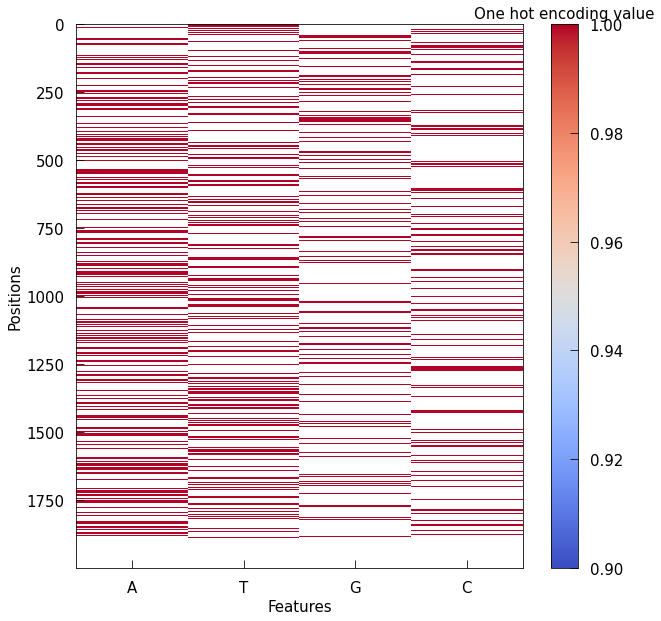

In [7]:
plt.figure(figsize = (10, 10))

plt.imshow(np.log10(10 * X_hot_encoded_train[1].view(2000, 4)), aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest', vmin=0.9, vmax=1)

cbar = plt.colorbar()
cbar.ax.set_title('One hot encoding value', fontsize=15)

plt.ylabel('Positions')
plt.xlabel('Features')

plt.xticks(np.arange(4), ['A', 'T', 'G', 'C'])

plt.show()

In [8]:
class Feedforward_block_drop_bn_opt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dro, relu_coeff):
        super(Feedforward_block_drop_bn_opt, self).__init__()
        self.input_size = input_size
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.hidden_size  = hidden_size
        self.fc = torch.nn.Linear(self.input_size, self.hidden_size)
        torch.nn.init.xavier_normal_(self.fc.weight, gain=torch.nn.init.calculate_gain('leaky_relu'))
        self.bn = torch.nn.BatchNorm1d(num_features=self.hidden_size)
        self.relu = torch.nn.LeakyReLU(self.relu_coeff)
        self.drop = torch.nn.Dropout(self.dro)
        
    def forward(self,x):
        hidden = self.fc(x)
        hidden = self.bn(hidden)
        hidden = self.drop(hidden)
        relu = self.relu(hidden)
        return relu
        
class Feedforward_deeper_drop_bn_opt(torch.nn.Module):
    def __init__(self, Feedforward_block_drop_bn_opt, archi, number_classes,dro,relu_coeff):
        super(Feedforward_deeper_drop_bn_opt, self).__init__()
        self.archi = archi
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = archi[-1][-1]
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
       
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x)
        output = self.drop(output)
        return output
    
    def _make_block(self, archi):
        layers = []
        for i in range(len(archi)):
            layers.append(Feedforward_block_drop_bn_opt(archi[i][0], archi[i][1], self.dro, self.relu_coeff))
        return torch.nn.Sequential(*layers)

In [9]:
def getBestModelfromTrials(trials):
    """ Get best model from trials
    So we don't have to retrain the model after parameter optimization.
    """
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

This new dataset being more complex to train and bigger, we will need to train it on gpus (even that is going to take a bit of time). I will point out the steps to do so.

In [10]:
def optimized_FFN(params, dat):
    x_train_3, y_train_3, x_val_3, y_val_3, _, _ = dat
    
    epochs = 3000
    
    archi = ((x_train_3.shape[1], 200), (200, 100), (100, 1))
    
    device = torch.device("cuda")
    
    model = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, archi, 1, params['dro'], params['relu_coeff'])
    model.to(device)
    
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['l_r'], weight_decay=params['wd'])
    
    keep_loss = []
    keep_loss_val = []
    keep_score = []
    keep_score_val = []
    for epoch in range(epochs):
        losses = []
        r2s = []
        losses_val = []
        r2s_val = []
        model.train()
        for d in range(0, len(x_train_3), params['batch_size']):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)].to(device))

            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)].to(device)).to(device)
            
            r2_train = metrics.r2_score(y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)], output_train.cpu().detach().numpy().tolist())
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            r2s.append(r2_train.item())
            
        model.eval()
        
        with torch.no_grad():
            for d in range(0, len(x_val_3), params['batch_size']):
                output_val = model(x_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].to(device))
                r2_val = metrics.r2_score(y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)], output_val.cpu().detach().numpy().tolist())
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].to(device))
                losses_val.append(loss_val.item())
                r2s_val.append(r2_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(r2s))
        keep_score_val.append(np.mean(r2s_val))
        
        if epoch == 0:
            keep_best_score = keep_score_val[-1]
            keep_best_loss = keep_loss_val[-1]
        else:
            if keep_loss_val[-1] < keep_best_loss:
                keep_model = model
                keep_best_score = keep_score_val[-1]
                keep_best_loss = keep_loss_val[-1]
                
        if epoch % 1000 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain r2: {} validation r2: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
            
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train r2: {} validation r2: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
            print('Params', params)
        
        if (epoch > 1000) and (keep_loss_val[-1] > keep_loss_val[-2] + 5 * np.std(keep_loss_val[-100:-1])):
            print('Params', params)
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('MSE loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('R2 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(keep_best_score)
    
    return {'loss': -keep_best_score, 'status': STATUS_OK, 'Trained_Model': keep_model.to('cpu')}

In [11]:
name = 'one_hot'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_hot_encod_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_hot_encod_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    x_train_3, _, _, _, _, _ = get_data_hot_encoded(list(df.ORF), list(df.Cramer.astype('float')), 2000)
    model_best_hot_encod_bigger = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, 
                                                                 ((x_train_3.shape[1], 200), (200, 100), (100, 1)), 
                                                                 1, 
                                                                 hp_best_hot_encod_bigger['drop_out_rate'], 
                                                                 hp_best_hot_encod_bigger['relu_coefficient'])
    model_best_hot_encod_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_hot_encod_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_FFN',
                      [{'dro':hp.uniform('drop_out_rate', 0.01, 0.2),
                        'relu_coeff':hp.uniform('relu_coefficient', 0, 0.5),
                        'wd':hp.uniform('weight_decay', 0.0001, 0.01),
                        'batch_size':hp.randint('mini_batch_size', 64, 64 * 5),
                        'l_r':hp.uniform('learning_rate', 0.001, 0.005)}])

    trials = Trials()
    hp_best_hot_encod_bigger = fmin(partial(optimized_FFN, dat=get_data_hot_encoded(list(df.ORF), list(df.Cramer.astype('float')), 2000)),
                                    space, 
                                    algo=tpe.suggest,
                                    max_evals=20,
                                    trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_hot_encod_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_hot_encod_bigger))
        
    # Save optimized neural network
    model_best_hot_encod_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_hot_encod_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))
    

Best hyperparameters:
{'drop_out_rate': 0.1674713169092225, 'learning_rate': 0.004527282720211086, 'mini_batch_size': 201, 'optimized_FFN': 0, 'relu_coefficient': 0.09780920854966291, 'weight_decay': 0.00633700341819448}


In [12]:
def truth_vs_pred(model, dat):    
    """ Visualize the results of the fits """
    
    model.eval()

    X_train, y_train, X_val, y_val, X_test, y_test = dat

    device = torch.device("cuda")
    
    model.to(device)

    y_pred_train = model(X_train.to(device)).cpu().detach().numpy()
    score_train = metrics.r2_score(y_train.numpy(), y_pred_train)

    y_pred_test = model(X_test.to(device)).cpu().detach().numpy()
    score_test = metrics.r2_score(y_test.numpy(), y_pred_test)

    y_pred_val = model(X_val.to(device)).cpu().detach().numpy()
    score_val = metrics.r2_score(y_val.numpy(), y_pred_val)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    im0 = ax[0].scatter(y_test.numpy(), y_pred_test, c=[dico_cramer_to_length[p] for p in np.array(y_test)], cmap='plasma')
    
    ax[0].set_title('r2 test= {:3f}'.format(score_test))
    ax[0].set_xlabel('True')
    ax[0].set_ylabel('Predicted')
    ax[0].plot([0, max(y_pred_test)], [0, max(y_pred_test)], 'k')
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(im0, cax=cax, orientation='vertical')
    clb.set_label('Length', labelpad=-40, y=1.05, rotation=0)

    im1 = ax[1].scatter(y_val.numpy(), y_pred_val, c=[dico_cramer_to_length[p] for p in np.array(y_val)], cmap='plasma')
    
    ax[1].set_title('r2 evaluation= {:3f}'.format(score_val))
    ax[1].set_xlabel('True')
    ax[1].set_ylabel('Predicted')
    ax[1].plot([0, max(y_pred_val)], [0,max(y_pred_val)], 'k')
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(im1, cax=cax, orientation='vertical')
    clb.set_label('Length', labelpad=-40, y=1.05, rotation=0)

    im2 = ax[2].scatter(y_train.numpy(), y_pred_train, c=[dico_cramer_to_length[p] for p in np.array(y_train)], cmap='plasma')
    
    ax[2].set_title('r2 train= {:3f}'.format(score_train))
    ax[2].set_xlabel('True')
    ax[2].set_ylabel('Predicted')
    ax[2].plot([0, max(y_pred_train)], [0, max(y_pred_train)], 'k')
    
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(im2, cax=cax, orientation='vertical')
    clb.set_label('Length', labelpad=-40, y=1.05, rotation=0)

    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    hist0 = ax[0].hist2d(y_test.numpy(), y_pred_test.reshape(1, -1)[0], 50, cmap='plasma', norm=LogNorm())
    
    ax[0].set_title('r2 test= {:3f}'.format(score_test))
    ax[0].set_xlabel('True')
    ax[0].set_ylabel('Predicted')
    ax[0].plot([0, max(y_pred_test)], [0,max(y_pred_test)], 'k')
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(hist0[3], cax=cax, orientation='vertical')
    
    hist1 = ax[1].hist2d(y_val.numpy(), y_pred_val.reshape(1, -1)[0], 50, cmap='plasma', norm=LogNorm())
    
    ax[1].set_title('r2 evaluation= {:3f}'.format(score_val))
    ax[1].set_xlabel('True')
    ax[1].set_ylabel('Predicted')
    ax[1].plot([0, max(y_pred_val)], [0,max(y_pred_val)], 'k')
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(hist1[3], cax=cax, orientation='vertical')

    hist2 = ax[2].hist2d(y_train.numpy(), y_pred_train.reshape(1, -1)[0], 50, cmap='plasma', norm=LogNorm())
    
    ax[2].set_title('r2 train= {:3f}'.format(score_train))
    ax[2].set_xlabel('True')
    ax[2].set_ylabel('Predicted')
    ax[2].plot([0, max(y_pred_train)], [0, max(y_pred_train)], 'k')
    
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(hist2[3], cax=cax, orientation='vertical')

    plt.tight_layout()
    plt.show()

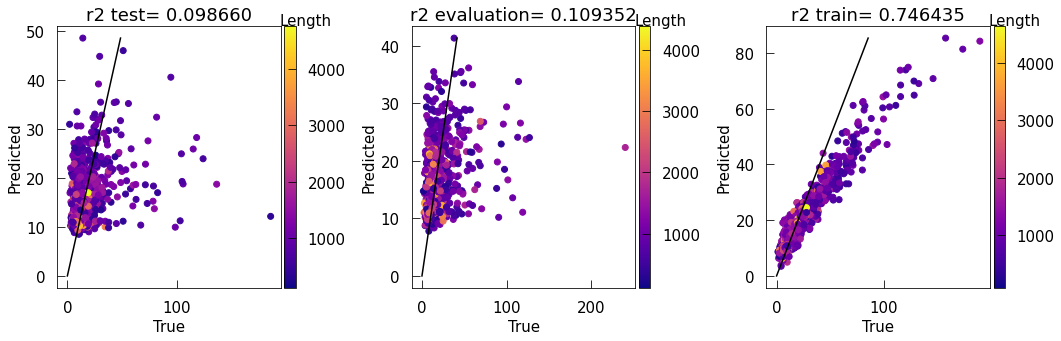

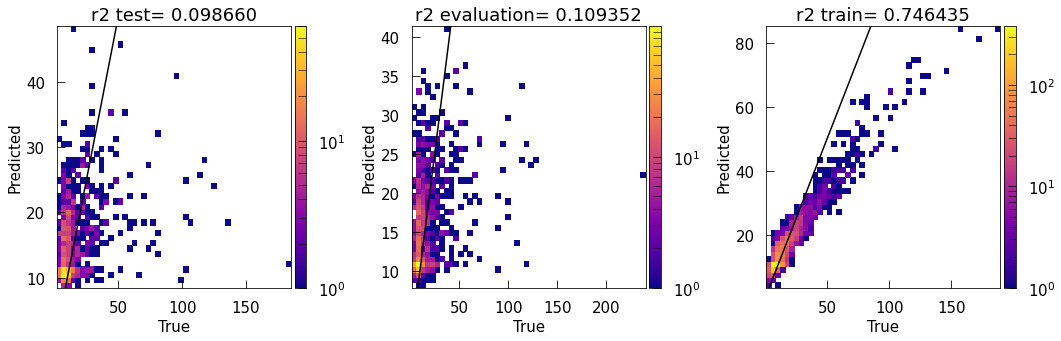

In [13]:
truth_vs_pred(model_best_hot_encod_bigger, get_data_hot_encoded(list(df.ORF), list(df.Cramer.astype('float32')), 2000))

# Word2vec <a class="anchor" id="word2vec"></a>

[Word2vec](https://en.wikipedia.org/wiki/Word2vec) is a neural network architecture with two linear layers. We will only talk about the skip gram flavour of it. Word2vec is a simple neural net that was developped in the field of Natural Language Processing (NLP). Since we are using characters, and since we are using characters too, it is worth giving it a try.

Word2vec deals with vocabularies, which are representations that one-hot encode the data as words in the context of a sentence. Imagine you could see your data as a bunch of words, with cardinality $V$, leading to a vocabulary of $V$ words. In Word2vec you start by representing words from the vocabulary you derived from your data as one-hot encoded vectors of dimension $V$.

But this representation is not very informative, as each word sits on the vertex of a V-dimensional hypercube. One could wish for words that appear often close to each other in sentences to also be close together in the vector space of their representation. Ideally, a lower-dimensional space (of dimension $N < V$), since words are not independent of each other and thus should not need $V$ dimensions to represent a vocabulary of $V$ words.

How do you go from an uninformative one-hot encoding to a nice representation space with meaningfull (similarity) metric? Word2vec proceeds as follows.

The first linear layer learns a representation of the one-hot encodings in an intermediate space of lower dimension. The second layer then brings this representation back to the initial space: it learn to produce one-hot encoded vectors like your original data. The full network is trained using a loss function that tries to maximize the likelihood that the encoded words in the output are near the input word in a sentence. In theory this strategy corresponds to a classification exercise on sets of words, and should result in calculating a cross-entropy with $M$ labels. This number $M$ is the count of all possible sets of neighboring words in a sentence.

---

*Remark:* You can find the sources for the following images [here](http://web.stanford.edu/class/cs224n/), [here](https://medium.com/analytics-vidhya/maths-behind-word2vec-explained-38d74f32726b), and [here](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

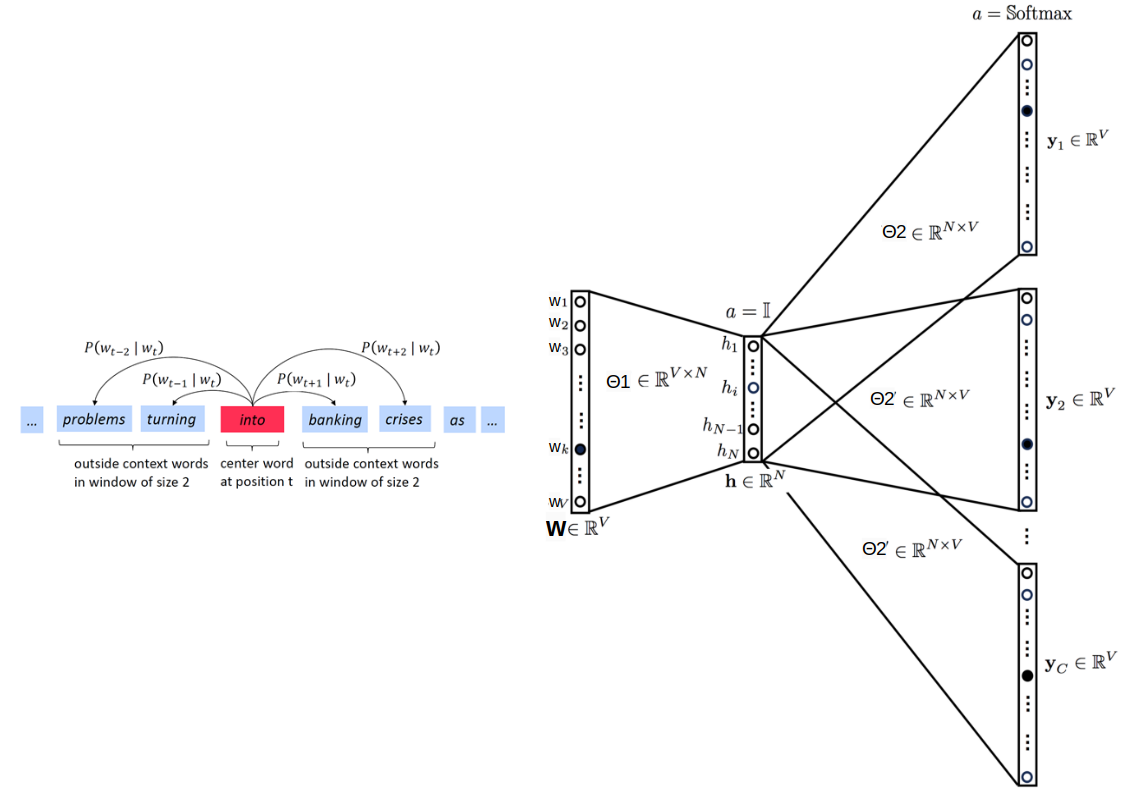

In [14]:
Image("images_sequences_number1/word2vec.png")

Let $T$ be the number of centered words you can fit in a sentence, $\Theta$ the collection of weights of the two linear layers, and $m$ be half of the size of the window. The loss function can then be written as

$$
-\frac{1}{T} \sum^{T}_{t=1}c\sum_{-m \leq j \leq m} P(w_{t + j} \mid w_{t}; \Theta)
$$

The conditional probabilities are taken from a softmax layer: 

$$
P(O=o \mid C=c) = \frac{e^{u_w^T v_c}}{\sum_{w \in \text{Vocab}} e^{u_o^T v_c}},
$$

where $o$ is the context word and $c$ the centered word. The $u$'s and $v$'s are vectors of weights from the two linear layers.


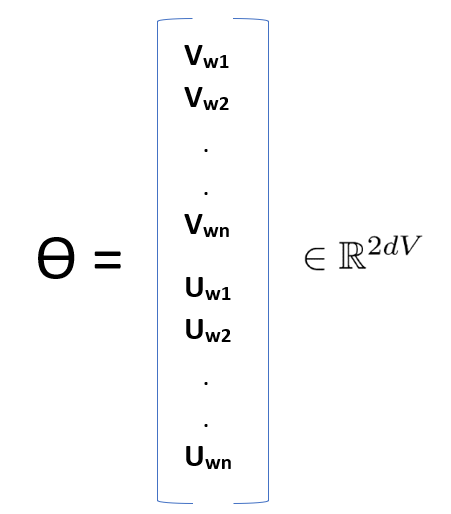

In [15]:
Image("images_sequences_number1/theta_word2vec.png")

We have glossed over the fact that there are no words in biological sequences, but we will make some up... 

In [16]:
kmers = 9

tokenized_corpus = [
    [s[k * kmers:(k + 1) * kmers] for k in range(0, int(len(s) / kmers)) if len(s[k * kmers:(k + 1) * kmers]) == kmers] for s in list(df.ORF)
]

sentences = [gensim.utils.simple_preprocess(' '.join(v)) for v in tokenized_corpus]

In [17]:
name = 'w2v_model2'

try:    
    # Load pre-trained embedding model
    w2v_model2 = gensim.models.Word2Vec.load(os.path.join('models', name + '.model'))
        
except FileNotFoundError:
    # Train embedding model
    w2v_model2 = Word2Vec(min_count=0, window=6, vector_size=250, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=11-1)

    t = time()
    w2v_model2.build_vocab(sentences, progress_per=1000)
    print('Time to build vocabulary: {} mins'.format(round((time() - t) / 60, 2)))
    
    t = time()
    w2v_model2.train(sentences, total_examples=w2v_model2.corpus_count, epochs=300, report_delay=1)
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

    w2v_model2.init_sims(replace=True)
    
    # Save model for later
    w2v_model2.save(os.path.join('models', name + '.model'))

In [18]:
len(w2v_model2.wv.key_to_index.keys())

168598

In [19]:
embedding_name = 'word2vec_ORF_emb_kmer_9_window_6_dim_250'

try:
    # Load pre-recorded sentence embeddings
    ok2_word = pd.read_csv(os.path.join('models', embedding_name + '.csv'))
    
except FileNotFoundError:
    # Compute embeddings
    def get_data2_word2vecs(sentences, y, model, l):

        data = []

        for i, sentence in enumerate(sentences):
            yep = model.wv.__getitem__(sentence[:l])
            data.append(list(yep.flatten()) + 250 * (l - yep.shape[0]) * [0])

        return pd.DataFrame([[s] + d + [y] for s, d, y in zip(sentences, data, y)])
    
    # Sentence embeddings
    ok2_word = get_data2_word2vecs(sentences, list(df.Cramer.astype('float')), w2v_model2, 32)
    
    # Save sentence embeddings as a CSV file
    ok2_word.to_csv(os.path.join('models', embedding_name + '.csv')) 
    
# Display a sample sentence embedding
ok2_word.sample()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,7992,7993,7994,7995,7996,7997,7998,7999,8000,8001
3011,3011,"['atggcaaat', 'actggctgt', 'ttatcacca', 'ggtgc...",0.029801,0.090571,0.052579,0.085762,-0.024379,-0.032132,-0.065935,-0.0526,...,0.009121,0.034437,0.018359,-0.101409,0.069823,-0.074345,-0.07816,-0.005417,-0.003889,22.546174


In [20]:
def get_data_word2vecs(sentences, y, model, l):
    
    data = []
    
    for i, sentence in enumerate(sentences):
        yep = model.wv.__getitem__(sentence[:l])
        data.append(np.array(list(yep.flatten()) + 250 * (l - yep.shape[0]) * [0]))
        
    data = np.array(data)
    y = np.array(y)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=0, test_size=0.2)
   
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size=0.3)
    
    X_train = torch.FloatTensor(np.array(X_train))
    y_train = torch.FloatTensor(np.array(y_train))
    X_val = torch.FloatTensor(np.array(X_val))
    y_val = torch.FloatTensor(np.array(y_val))
    X_test = torch.FloatTensor(np.array(X_test))
    y_test = torch.FloatTensor(np.array(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test            

To keep the input layer at the same size as the one-hot encoding above (8000), and since the 9 mers are coded in 250 dimensions, we look only at the first 32 9 mers (i.e. the 288 first nucleotides). The problem with this is two-fold: we arbitrarly set what's a word, and the network will become large very quickly. We should try instead to embed the sequence rather than the words that composes it.

In [21]:
name = 'word2vec'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_word2vec_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_word2vec_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    x_train_3, _, _, _, _, _ = get_data_word2vecs(sentences, list(df.Cramer.astype('float')), w2v_model2, 32)
    model_best_word2vec_bigger = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, 
                                                                 ((x_train_3.shape[1], 200), (200, 100), (100, 1)), 
                                                                 1, 
                                                                 hp_best_word2vec_bigger['drop_out_rate'], 
                                                                 hp_best_word2vec_bigger['relu_coefficient'])
    model_best_word2vec_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_word2vec_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_FFN',
                      [{'dro':hp.uniform('drop_out_rate', 0.01, 0.2),
                        'relu_coeff':hp.uniform('relu_coefficient', 0, 0.5),
                        'wd':hp.uniform('weight_decay', 0.0001, 0.01),
                        'batch_size':hp.randint('mini_batch_size', 64, 64 * 5),
                        'l_r':hp.uniform('learning_rate', 0.001, 0.005)}])
    
    trials = Trials()
    hp_best_word2vec_bigger = fmin(partial(optimized_FFN, dat=get_data_word2vecs(sentences, list(df.Cramer.astype('float')), w2v_model2, 32)), 
                                   space, 
                                   algo=tpe.suggest, 
                                   max_evals=20,
                                   trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_word2vec_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_word2vec_bigger))
        
    # Save optimized neural network
    model_best_word2vec_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_word2vec_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))
    

Best hyperparameters:
{'drop_out_rate': 0.01602123890607794, 'learning_rate': 0.002486891327002859, 'mini_batch_size': 168, 'optimized_FFN': 0, 'relu_coefficient': 0.08389974353521373, 'weight_decay': 0.0001803350482612826}


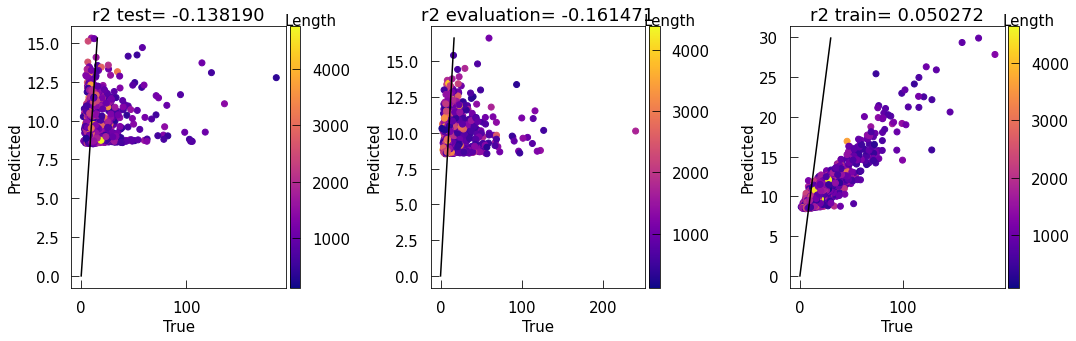

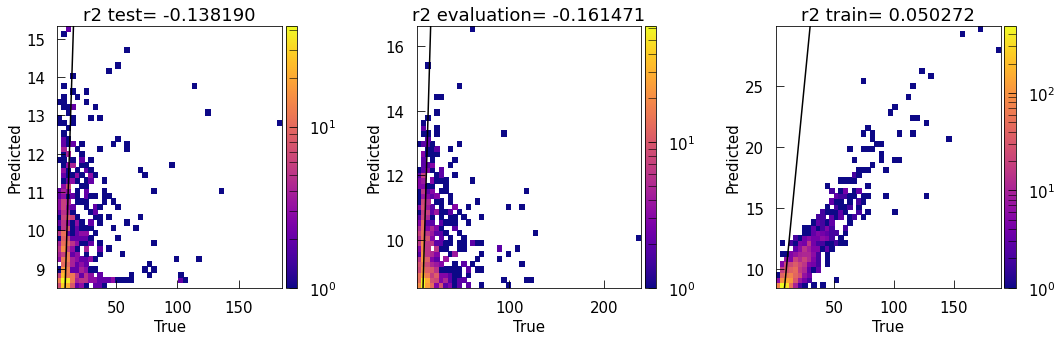

In [22]:
truth_vs_pred(model_best_word2vec_bigger, get_data_word2vecs(sentences, list(df.Cramer.astype('float')), w2v_model2, 32))

# Doc2Vec <a class="anchor" id="doc2vec"></a>

A better way to deal with sequences, at least one where that does not make the dimensions explode, is to treat the whole sequence as a one-hot encoded vector. This is what [Doc2vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) does. It is just like Word2vec but it looks at the full disordered sequences of words ("documents") and tries to put them close together in some subspace if they share word usage. We are now not really bound by cardinality (every sequence will be described by a fix set of coordinates), so we can work a bit more intelligently. 

For each sequence we will derive the sets of all $k$ contiguous caracters present in it. We will treat that as a document and embdd it in a space of documents.

In [23]:
kmers = 9

seq_as_doc = []

for s in list(df.ORF):
    sent = []
    for i in range(kmers):
        sent.append(' '.join([s[i:][k * kmers:(k + 1) * kmers] for k in range(0, int(len(s) / kmers)) if len(s[i:][k * kmers:(k + 1) * kmers]) == kmers]))
    
    seq_as_doc.append(' '.join(sent))    

In [24]:
tagged_data = [TaggedDocument(words=[d.lower() for d in _d.split(' ')], tags=[str(i)]) for i, _d in enumerate(seq_as_doc)]

In [25]:
name = 'Doc2Vec_model'

try:    
    # Load pre-trained embedding model
    Doc2Vec_model = gensim.models.Doc2Vec.load(os.path.join('models', name + '.model'))
        
except FileNotFoundError:
    # Train embedding model
    max_epochs = 100
    vec_size = 250
    alpha = 0.025

    Doc2Vec_model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)

    t = time()
    Doc2Vec_model.build_vocab(tagged_data)
    print('Time to build vocabulary: {} mins'.format(round((time() - t) / 60, 2)))
    
    t = time()
    Doc2Vec_model.train(tagged_data, total_examples=Doc2Vec_model.corpus_count, epochs=100)
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
    
    # Save model for later
    Doc2Vec_model.save(os.path.join('models', name + '.model'))

In [26]:
def get_data_doc2vecs(seq_as_docs, y, model):
    
    data = []
    
    for i in range(len(seq_as_docs)):
        yep = model.docvecs[str(i)]
        data.append(yep)
    
    data = np.array(data)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=0, test_size=0.2)
   
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size=0.3)
    
    X_train = torch.FloatTensor(np.array(X_train))
    y_train = torch.FloatTensor(np.array(y_train))
    X_val = torch.FloatTensor(np.array(X_val))
    y_val = torch.FloatTensor(np.array(y_val))
    X_test = torch.FloatTensor(np.array(X_test))
    y_test = torch.FloatTensor(np.array(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [27]:
name = 'doc2vec'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_doc2vec_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_doc2vec_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    x_train_3, _, _, _, _, _ = get_data_doc2vecs(seq_as_doc, list(df.Cramer.astype('float')), Doc2Vec_model)
    model_best_doc2vec_bigger = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, 
                                                               ((x_train_3.shape[1], 200), (200, 100), (100, 1)), 
                                                               1, 
                                                               hp_best_doc2vec_bigger['drop_out_rate'], 
                                                               hp_best_doc2vec_bigger['relu_coefficient'])
    model_best_doc2vec_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_doc2vec_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_FFN',
                      [{'dro':hp.uniform('drop_out_rate', 0.01, 0.2),
                        'relu_coeff':hp.uniform('relu_coefficient', 0, 0.5),
                        'wd':hp.uniform('weight_decay', 0.0001, 0.01),
                        'batch_size':hp.randint('mini_batch_size', 64, 64 * 5),
                        'l_r':hp.uniform('learning_rate', 0.001, 0.005)}])
    trials = Trials()
    hp_best_doc2vec_bigger = fmin(partial(optimized_FFN, dat=get_data_doc2vecs(seq_as_doc, list(df.Cramer.astype('float')), Doc2Vec_model)), 
                                  space, 
                                  algo=tpe.suggest, 
                                  max_evals=20,
                                  trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_doc2vec_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_doc2vec_bigger))
        
    # Save optimized neural network
    model_best_doc2vec_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_doc2vec_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))
    

Best hyperparameters:
{'drop_out_rate': 0.02662403174628626, 'learning_rate': 0.0010871456250740312, 'mini_batch_size': 120, 'optimized_FFN': 0, 'relu_coefficient': 0.1159639609373963, 'weight_decay': 0.0047348525459437974}


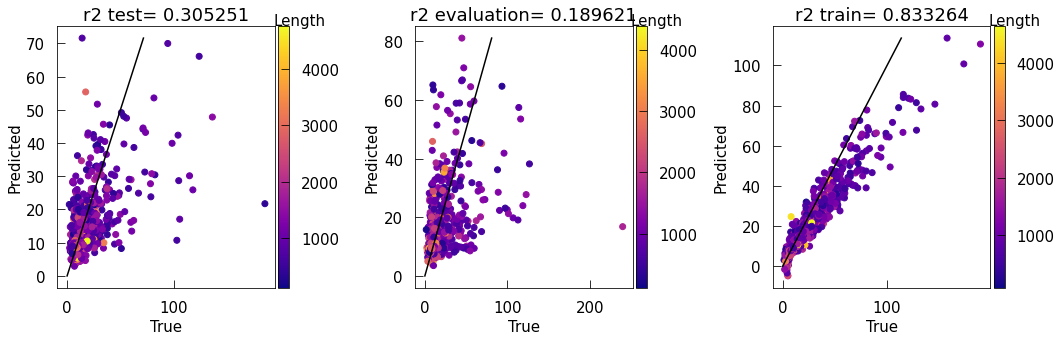

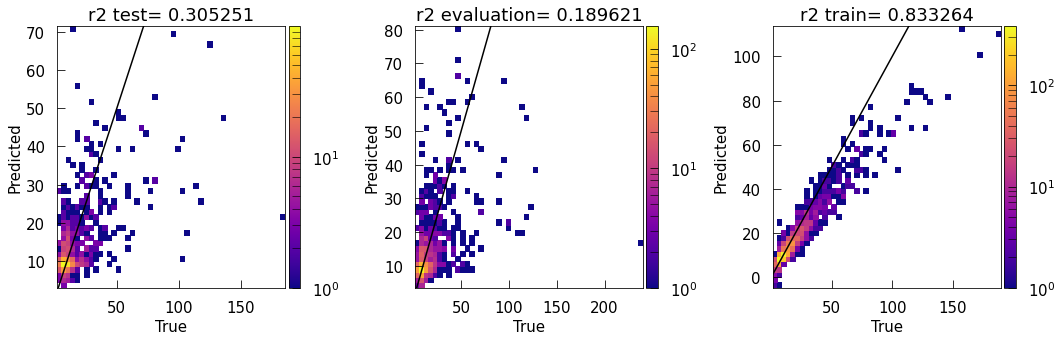

In [28]:
truth_vs_pred(model_best_doc2vec_bigger, get_data_doc2vecs(seq_as_doc, list(df.Cramer.astype('float')), Doc2Vec_model))

In [29]:
embedding_name = 'ORF_docemb_9mers_dim_250'

try:
    # Load pre-recorded sentence embeddings
    ok2 = pd.read_csv(os.path.join('models', embedding_name + '.csv'))
    
except FileNotFoundError:
    # Compute embeddings
    def get_data2_doc2vecs(sentences, seq_as_docs, y, model):
        data = []

        for i in range(len(seq_as_docs)):
            yep = list(model.docvecs[str(i)])
            data.append(yep)

        return pd.DataFrame([[s] + d + [y] for s, d, y in zip(sentences, data, y)])
    
    # Document embeddings
    ok2 = get_data2_doc2vecs(list(df.ORF), seq_as_doc, list(df.Cramer.astype('float')), Doc2Vec_model)
    
    # Save document embeddings as a CSV file
    ok2.to_csv(os.path.join('models', embedding_name + '.csv')) 
    
# Display a sample sentence embedding
ok2.sample()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,242,243,244,245,246,247,248,249,250,251
2521,2521,ATGGACACAAATTCTAAAACCAAAGTACAAACTGAAAATAAAAAAA...,1.261976,-6.451137,2.405012,2.600076,5.080907,0.431205,0.988372,2.203004,...,3.260647,-1.431332,1.585879,6.437011,4.574937,1.382603,4.365972,0.067136,5.893912,11.428876


# Trying homemade features <a class="anchor" id="homemade_features"></a>

A brief literature check for relevant features in the task of transcript decay rate prediction seems to point to length of ORF and UTRs as well as their GC content. So in the following few cells we are going to compute the nucleotide usage of each sequences as well as their length and feed them to our feedforward network.

---

*Remark:* We will need to scale those different features as they code for different things.

In [30]:
def get_ATGC_distri(sequences, ID): 
    dico_ATGC_res = {Id:[0, 0, 0, 0] for Id in ID}
    dico_ATGC={'A':0, 'T':1, 'G':2, 'C':3}
    for i, sequence in enumerate(sequences):
        for s in sequence:
            dico_ATGC_res[ID[i]][dico_ATGC[s]] += 1. / len(sequence)
    return dico_ATGC_res

In [31]:
dico_ATGC_3 = get_ATGC_distri(list(df['3UTR']), list(df['ID']))
dico_ATGC_5 = get_ATGC_distri(list(df['5UTR']), list(df['ID']))
dico_ATGC_ORF = get_ATGC_distri(list(df['ORF']), list(df['ID']))

In [32]:
df_homemade = pd.DataFrame([[ID, 
                             dico_ATGC_3[ID][0],
                             dico_ATGC_3[ID][1],
                             dico_ATGC_3[ID][2],
                             dico_ATGC_3[ID][3],
                             dico_ATGC_5[ID][0],
                             dico_ATGC_5[ID][1],
                             dico_ATGC_5[ID][2],
                             dico_ATGC_5[ID][3],
                             dico_ATGC_ORF[ID][0],
                             dico_ATGC_ORF[ID][1],
                             dico_ATGC_ORF[ID][2],
                             dico_ATGC_ORF[ID][3],
                             np.log10(len(s1)),
                             np.log10(len(s2)),
                             np.log10(len(s3)),
                             float(c)] for ID, s1, s2, s3, c in zip(list(df['ID']),
                                                                    list(df['5UTR']),
                                                                    list(df['3UTR']),
                                                                    list(df['ORF']),
                                                                    list(df['Cramer']))])

In [33]:
def get_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size=0.3)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    X_train = torch.FloatTensor(np.array(X_train))
    y_train = torch.FloatTensor(np.array(y_train))
    X_val = torch.FloatTensor(np.array(X_val))
    y_val = torch.FloatTensor(np.array(y_val))
    X_test = torch.FloatTensor(np.array(X_test))
    y_test = torch.FloatTensor(np.array(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [34]:
name = 'homemade'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_homemade_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_homemade_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    x_train_3, _, _, _, _, _ = get_data(np.array(df_homemade[list(df_homemade.columns)[1:-1]]), list(df.Cramer.astype('float')))
    model_best_homemade_bigger = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, 
                                                                 ((x_train_3.shape[1], 200), (200, 100), (100, 1)), 
                                                                 1, 
                                                                 hp_best_homemade_bigger['drop_out_rate'], 
                                                                 hp_best_homemade_bigger['relu_coefficient'])
    model_best_homemade_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_homemade_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_FFN',
                      [{'dro':hp.uniform('drop_out_rate', 0.01, 0.2),
                        'relu_coeff':hp.uniform('relu_coefficient', 0, 0.5),
                        'wd':hp.uniform('weight_decay', 0.0001, 0.01),
                        'batch_size':hp.randint('mini_batch_size', 64, 64 * 5),
                        'l_r':hp.uniform('learning_rate', 0.001, 0.005)}])
    trials = Trials()
    hp_best_homemade_bigger = fmin(partial(optimized_FFN, 
                                           dat=get_data(np.array(df_homemade[list(df_homemade.columns)[1:-1]]), list(df.Cramer.astype('float')))), 
                                   space, 
                                   algo=tpe.suggest, 
                                   max_evals=20,
                                   trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_homemade_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_homemade_bigger))
        
    # Save optimized neural network
    model_best_homemade_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_homemade_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))

Best hyperparameters:
{'drop_out_rate': 0.015846136458222398, 'learning_rate': 0.0041474730879289675, 'mini_batch_size': 252, 'optimized_FFN': 0, 'relu_coefficient': 0.03900092911911446, 'weight_decay': 0.00496668815777244}


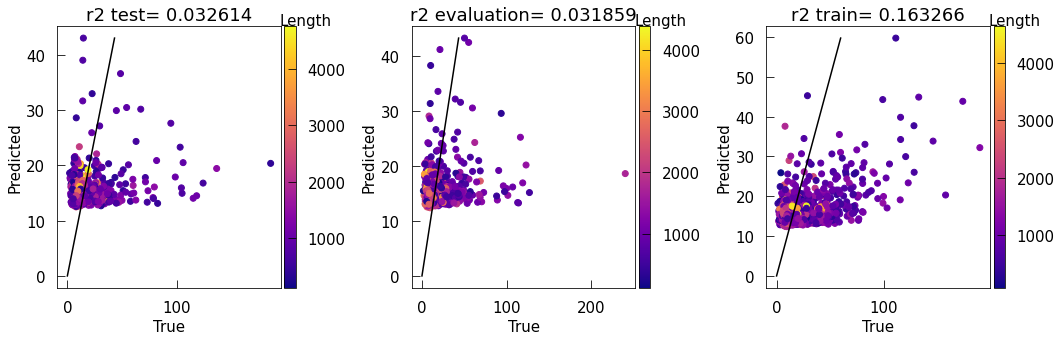

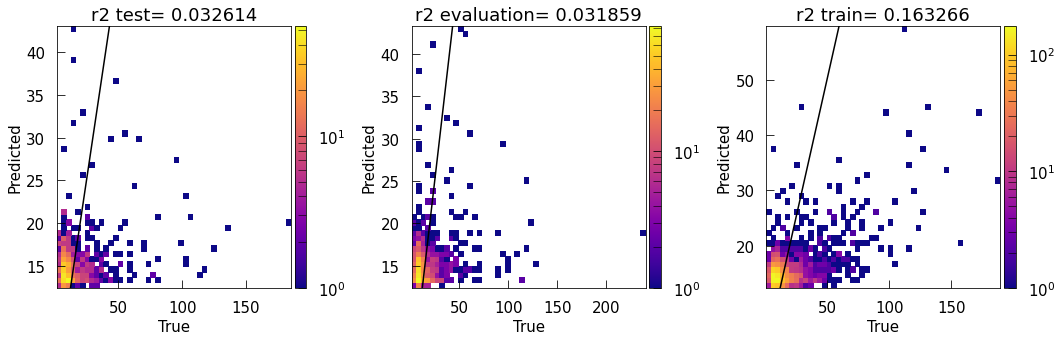

In [35]:
truth_vs_pred(model_best_homemade_bigger, get_data(np.array(df_homemade[list(df_homemade.columns)[1:-1]]), list(df.Cramer.astype('float'))))

# Bringing homemade and Doc2Vec together <a class="anchor" id="homemade_and_doc2vec"></a>

Let's now have a model using both the Doc2vec features and our homemade ones.

In [36]:
df_mix = pd.concat([df_homemade[list(df_homemade.columns)[0:-1]], ok2[list(ok2.columns)[2:-1]]], axis=1)
df_mix['Cramer'] = df_homemade[list(df_homemade.columns)[-1]]

In [37]:
name = 'mix'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_mix_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_mix_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    x_train_3, _, _, _, _, _ = get_data(np.array(df_mix[list(df_mix.columns)[1:-1]]), list(df.Cramer.astype('float')))
    model_best_mix_bigger = Feedforward_deeper_drop_bn_opt(Feedforward_block_drop_bn_opt, 
                                                                 ((x_train_3.shape[1], 200), (200, 100), (100, 1)), 
                                                                 1, 
                                                                 hp_best_mix_bigger['drop_out_rate'], 
                                                                 hp_best_mix_bigger['relu_coefficient'])
    model_best_mix_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_mix_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_FFN',
                      [{'dro':hp.uniform('drop_out_rate', 0.01, 0.2),
                        'relu_coeff':hp.uniform('relu_coefficient', 0, 0.5),
                        'wd':hp.uniform('weight_decay', 0.0001, 0.01),
                        'batch_size':hp.randint('mini_batch_size', 64, 64 * 5),
                        'l_r':hp.uniform('learning_rate', 0.001, 0.005)}])
    trials = Trials()
    hp_best_mix_bigger = fmin(partial(optimized_FFN, dat=get_data(np.array(df_mix[list(df_mix.columns)[1:-1]]), list(df.Cramer.astype('float')))), 
                              space, 
                              algo=tpe.suggest, 
                              max_evals=20,
                              trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_mix_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_mix_bigger))
        
    # Save optimized neural network
    model_best_mix_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_mix_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))
    

Best hyperparameters:
{'drop_out_rate': 0.012903581252365135, 'learning_rate': 0.004726678250089104, 'mini_batch_size': 112, 'optimized_FFN': 0, 'relu_coefficient': 0.039693441559271625, 'weight_decay': 0.004513004233203424}


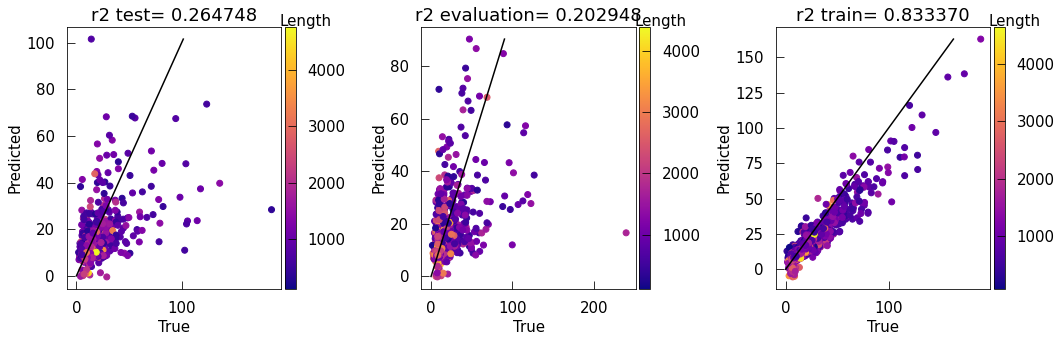

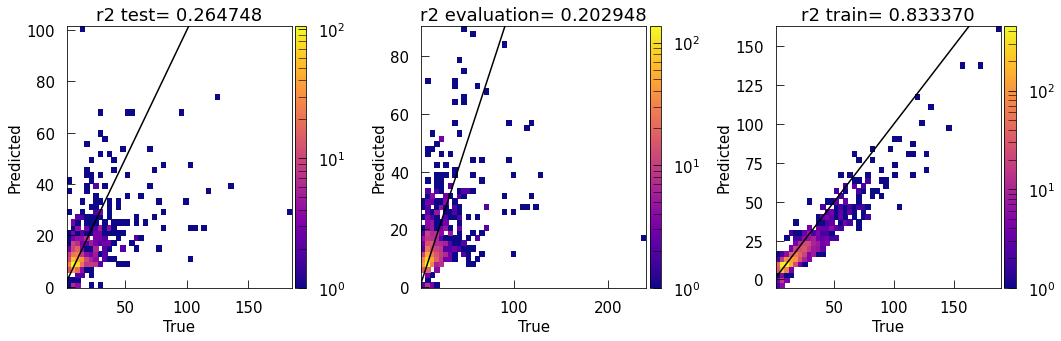

In [38]:
truth_vs_pred(model_best_mix_bigger, get_data(np.array(df_mix[list(df_mix.columns)[1:-1]]), list(df.Cramer.astype('float'))))

The combination was not very usefull overall. The Doc2vec representation probably already captures most of the information from our homemade features.

# Convolutional layers <a class="anchor" id="conv_layers"></a>

In [39]:
dico_ATGC = {'A':[1, 0, 0, 0], 'T':[0, 1, 0, 0], 'G':[0, 0, 1, 0], 'C':[0, 0, 0, 1]}

def get_data_image_4channels_encoded(sentences, y, l):
    
    data = np.zeros((len(sentences), l, 4), dtype='f')
    
    for i, sentence in enumerate(sentences):
        for f, v in enumerate(sentence[:l]):
            data[i][f] = np.array(dico_ATGC[v])
       
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=0, test_size=0.2)
   
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size=0.3)
    
    X_train = torch.FloatTensor(np.array(X_train)).permute(0,2,1)
    y_train = torch.FloatTensor(np.array(y_train))
    X_val = torch.FloatTensor(np.array(X_val)).permute(0,2,1)
    y_val = torch.FloatTensor(np.array(y_val))
    X_test = torch.FloatTensor(np.array(X_test)).permute(0,2,1)
    y_test = torch.FloatTensor(np.array(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test    

In [40]:
class LeNet_block_drop_bn_opt(torch.nn.Module):
    def __init__(self, in_channels, out_channels, relu_coeff, max_pool_kern_size, conv_kern_size):
        super(LeNet_block_drop_bn_opt, self).__init__()
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.conv1 = torch.nn.Conv1d(in_channels, out_channels, kernel_size=self.conv_kern_size, stride=1, padding=int(self.conv_kern_size / 2))
        self.relu = torch.nn.LeakyReLU(self.relu_coeff)
        self.pool = torch.nn.MaxPool1d(kernel_size=self.max_pool_kern_size)
        
    def forward(self, x):
        hidden = self.conv1(x)
        hidden = self.relu(hidden)
        maxpool = self.pool(hidden)
        return maxpool
        
class LeNet_deeper_drop_bn_opt(torch.nn.Module):
    def __init__(self, LeNet_block_drop_bn_opt, archi, number_classes, dro, relu_coeff, max_pool_kern_size, conv_kern_size, output_size):
        super(LeNet_deeper_drop_bn_opt, self).__init__()
        self.archi = archi
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = output_size
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
       
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x.view(x.shape[0], x.size(1) * x.size(2)))
        output = self.drop(output)
        return output
    
    def _make_block(self, archi):
        layers = []
        for i in range(len(archi)):
            layers.append(LeNet_block_drop_bn_opt(archi[i][0], archi[i][1], self.relu_coeff, self.max_pool_kern_size, self.conv_kern_size))
        return torch.nn.Sequential(*layers)

We will go for two layers of convolutions. The first will train 32 kernels, and the second 64. All convolutions will have a kernel size of 3, and we will use a maxpooling mask of 4. Feel free to change all of that.

In [41]:
def optimized_LeNet(params, dat):
    
    x_train_3, y_train_3, x_val_3, y_val_3, _, _ = dat
    
    epochs = 3000
    
    archi = ((4, 32), (32, 64))
    
    device = torch.device("cuda")
    model = LeNet_deeper_drop_bn_opt(LeNet_block_drop_bn_opt, archi, 1, params['dro'], params['relu_coeff'], 4, 3, 64 * 128)
    model.to(device)
    
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['l_r'], weight_decay=params['wd'])
    
    keep_loss=[]
    keep_loss_val=[]
    keep_score=[]
    keep_score_val=[]
    for epoch in range(epochs):
        losses = []
        r2s = []
        losses_val = []
        r2s_val = []
        model.train()
        for d in range(0, len(x_train_3), params['batch_size']):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)].to(device))

            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)].to(device)).to(device)
            
            r2_train = metrics.r2_score(y_train_3[d:min(d+params['batch_size'], len(x_train_3) - 1)], output_train.cpu().detach().numpy().tolist())
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            r2s.append(r2_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), params['batch_size']):
                output_val = model(x_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].to(device))
                r2_val = metrics.r2_score(y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)], output_val.cpu().detach().numpy().tolist())
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].to(device))
                losses_val.append(loss_val.item())
                r2s_val.append(r2_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(r2s))
        keep_score_val.append(np.mean(r2s_val))
        
        if epoch == 0:
            keep_best_score = keep_score_val[-1]
            keep_best_loss = keep_loss_val[-1]
        else:
            if keep_loss_val[-1] < keep_best_loss:
                keep_model = model
                keep_best_score = keep_score_val[-1]
                keep_best_loss = keep_loss_val[-1]
                
        if epoch % 1000 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain r2: {} validation r2: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
            
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train r2: {} validation r2: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
            print('Params', params)
        
        if (epoch > 1000) and (keep_loss_val[-1] > keep_loss_val[-2] + 5 * np.std(keep_loss_val[-100:-1])):
            print('Params', params)
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('MSE loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('R2 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(keep_best_score)
    
    return {'loss': -keep_best_score, 'status': STATUS_OK, 'Trained_Model': keep_model.to('cpu')}

In [42]:
name = 'conv1d'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_conv1d_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_conv1d_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    model_best_conv1d_bigger = LeNet_deeper_drop_bn_opt(LeNet_block_drop_bn_opt, 
                                                        ((4, 32), (32, 64)), 
                                                        1,
                                                        hp_best_conv1d_bigger['drop_out_rate'], 
                                                        hp_best_conv1d_bigger['relu_coefficient'], 
                                                        4, 
                                                        3, 
                                                        64 * 128)
    model_best_conv1d_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_conv1d_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_LeNet',
                      [{'dro':hp.uniform('drop_out_rate',0.01,0.2),
                        'relu_coeff':hp.uniform('relu_coefficient',0,0.5),
                        'wd':hp.uniform('weight_decay',0.0001,0.01),
                        'batch_size':hp.randint('mini_batch_size',64,64*5),
                        'l_r':hp.uniform('learning_rate',0.001,0.005)}])

    trials = Trials()
    hp_best_conv1d_bigger = fmin(partial(optimized_LeNet, 
                                         dat=get_data_image_4channels_encoded(list(df.ORF), list(df.Cramer.astype('float')), 2048)), 
                                 space, 
                                 algo=tpe.suggest, 
                                 max_evals=20,
                                 trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_conv1d_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_conv1d_bigger))
        
    # Save optimized neural network
    model_best_conv1d_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_conv1d_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))
    

Best hyperparameters:
{'drop_out_rate': 0.015295060283306487, 'learning_rate': 0.0025541895663578453, 'mini_batch_size': 276, 'optimized_FFN': 0, 'relu_coefficient': 0.27587730183596043, 'weight_decay': 0.004964434826285957}


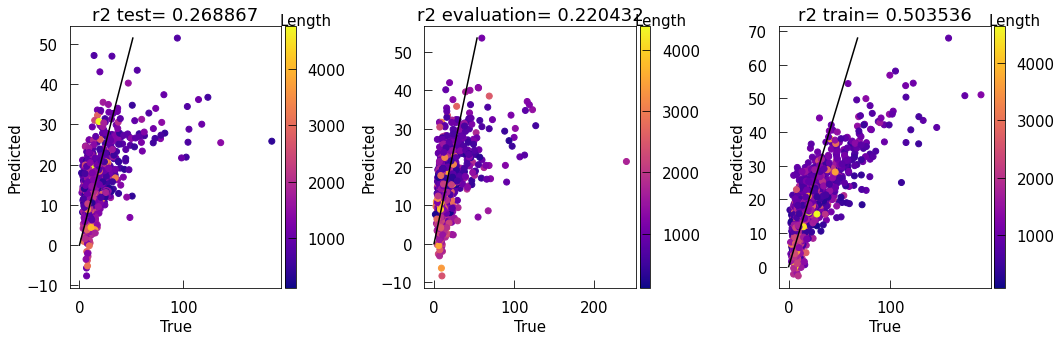

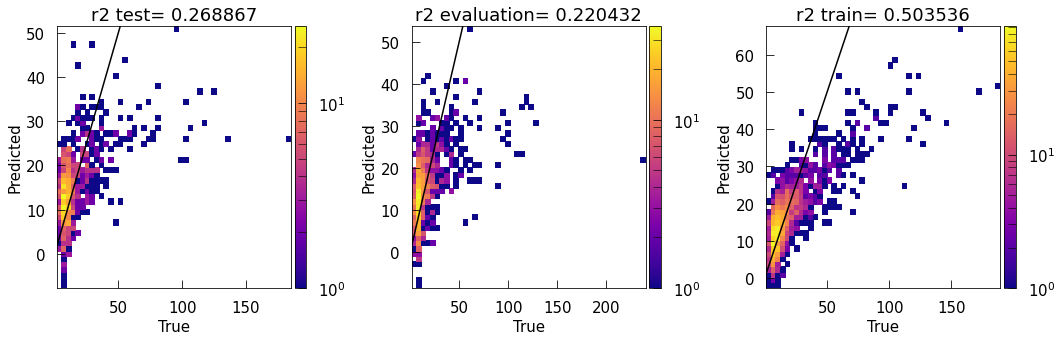

In [43]:
truth_vs_pred(model_best_conv1d_bigger, get_data_image_4channels_encoded(list(df.ORF), list(df.Cramer.astype('float')), 2048))

In [44]:
def get_data_image_2d_encoded(sentences, y, l):
    
    data = np.zeros((len(sentences), 1, l, 4), dtype='f')
    
    for i, sentence in enumerate(sentences):
        for f, v in enumerate(sentence[:l]):
            data[i][0][f] = np.array(dico_ATGC[v])
       
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=0, test_size=0.2)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size=0.3)
    
    X_train = torch.FloatTensor(np.array(X_train))
    y_train = torch.FloatTensor(np.array(y_train))
    X_val = torch.FloatTensor(np.array(X_val))
    y_val = torch.FloatTensor(np.array(y_val))
    X_test = torch.FloatTensor(np.array(X_test))
    y_test = torch.FloatTensor(np.array(y_test))
    
    return X_train, y_train, X_val, y_val, X_test, y_test        

In [45]:
class LeNet2d_block_drop_bn_opt(torch.nn.Module):
    def __init__(self, in_channels, out_channels, relu_coeff, max_pool_kern_size, conv_kern_size):
        super(LeNet2d_block_drop_bn_opt, self).__init__()
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=self.conv_kern_size, stride=1, padding=int(self.conv_kern_size / 2))
        self.relu = torch.nn.LeakyReLU(self.relu_coeff)
        self.pool = torch.nn.MaxPool2d(kernel_size=self.max_pool_kern_size)
        
    def forward(self, x):
        hidden = self.conv1(x)
        hidden = self.relu(hidden)
        maxpool = self.pool(hidden)
        return maxpool
        
class LeNet2d_deeper_drop_bn_opt(torch.nn.Module):
    def __init__(self, LeNet2d_block_drop_bn_opt, archi, number_classes, dro, relu_coeff, max_pool_kern_size, conv_kern_size, output_size):
        super(LeNet2d_deeper_drop_bn_opt, self).__init__()
        self.archi = archi
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = output_size
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
    
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x.view(x.shape[0], x.size(1) * x.size(2)))
        output = self.drop(output)
        return output
    
    def _make_block(self, archi):
        layers = []
        for i in range(len(archi)):
            layers.append(LeNet2d_block_drop_bn_opt(archi[i][0], archi[i][1], self.relu_coeff, self.max_pool_kern_size, self.conv_kern_size))
        return torch.nn.Sequential(*layers)

We will go for two layers of convolutions. The first will train 32 kernels and the second 64. Both with a kernel size of 4, and we will use a maxpooling mask of 4 by 2. Feel free to change all of that but if you do please explain the rational of why. 

In my case, the kernel of size 4 was to make sure that a single convolution would take the 4 nucleotide dimensions into account every time. I don't see what a smaller convolution would mean as it would then depend on the ordering of your nucleotides. The maxpooling is here to be efficient in both dimensions: a 2-by-2 size was not reducing the dimension enough to my taste but a 4-by-4 would "get rid" of the whole channel after the first layer and inhibit the work of the second layer. Compromises.

In [46]:
def optimized_LeNet2d(params, dat):
    
    x_train_3, y_train_3, x_val_3, y_val_3, _, _ = dat
    
    epochs  = 3000
    
    archi=((1, 32), (32,64))

    device = torch.device("cuda")
    
    model = LeNet2d_deeper_drop_bn_opt(LeNet2d_block_drop_bn_opt, archi, 1, params['dro'], params['relu_coeff'], (4, 2), 4, 64 * 128)
    model.to(device)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['l_r'], weight_decay=params['wd'])
    
    keep_loss = []
    keep_loss_val = []
    keep_score = []
    keep_score_val = []
    for epoch in range(epochs):
        losses = []
        r2s = []
        losses_val = []
        r2s_val = []
        model.train()
        for d in range(0, len(x_train_3), params['batch_size']):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)].to(device))

            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)].to(device)).to(device)
            
            r2_train = metrics.r2_score(y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)], output_train.cpu().detach().numpy().tolist())
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            r2s.append(r2_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), params['batch_size']):
                output_val = model(x_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].to(device))
                r2_val = metrics.r2_score(y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)], output_val.cpu().detach().numpy().tolist())
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].to(device))
                losses_val.append(loss_val.item())
                r2s_val.append(r2_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(r2s))
        keep_score_val.append(np.mean(r2s_val))
        
        if epoch == 0:
            keep_best_score = keep_score_val[-1]
            keep_best_loss = keep_loss_val[-1]
        else:
            if keep_loss_val[-1] < keep_best_loss:
                keep_model = model
                keep_best_score = keep_score_val[-1]
                keep_best_loss = keep_loss_val[-1]
                
        if epoch % 1000 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain r2: {} validation r2: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
            
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train r2: {} validation r2: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
            print('Params', params)        
        
        if (epoch > 1000) and (keep_loss_val[-1] > keep_loss_val[-2] + 5 * np.std(keep_loss_val[-100:-1])):
            print('Params', params)
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('MSE loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('R2 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(keep_best_score)
    
    return {'loss': -keep_best_score, 'status': STATUS_OK, 'Trained_Model': keep_model.to('cpu')}

In [47]:
name = 'conv2d'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_conv2d_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_conv2d_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    x_train_3, _, _, _, _, _ = get_data_word2vecs(sentences, list(df.Cramer.astype('float')), w2v_model2, 32)
    model_best_conv2d_bigger = LeNet2d_deeper_drop_bn_opt(LeNet2d_block_drop_bn_opt, 
                                                          ((1, 32), (32,64)), 
                                                          1, 
                                                          hp_best_conv2d_bigger['drop_out_rate'], 
                                                          hp_best_conv2d_bigger['relu_coefficient'], 
                                                          (4, 2), 
                                                          4, 
                                                          64 * 128)
    model_best_conv2d_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_conv2d_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_LeNet2d', 
                      [{'dro':hp.uniform('drop_out_rate',0.01,0.2),
                        'relu_coeff':hp.uniform('relu_coefficient',0,0.5),
                        'wd':hp.uniform('weight_decay',0.0001,0.01),
                        'batch_size':hp.randint('mini_batch_size',64,64*5),
                        'l_r':hp.uniform('learning_rate',0.001,0.005)}])

    trials = Trials()
    hp_best_conv2d_bigger = fmin(partial(optimized_LeNet2d, dat=get_data_image_2d_encoded(list(df.ORF), list(df.Cramer.astype('float')), 2048)), 
                                 space, 
                                 algo=tpe.suggest, 
                                 max_evals=20,
                                 trials=trials)

    print("Best hyperparameters:")
    print(hp_best_conv2d_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_conv2d_bigger))
        
    # Save optimized neural network
    model_best_conv2d_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_conv2d_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))
    

Best hyperparameters:
{'drop_out_rate': 0.11558308641435501, 'learning_rate': 0.004935876536405342, 'mini_batch_size': 299, 'optimized_LeNet2d': 0, 'relu_coefficient': 0.004301882424385117, 'weight_decay': 0.0033192849627214868}


In [48]:
def truth_vs_pred2(model, dat):    
    
    model.eval()

    X_train, y_train, X_val, y_val, X_test, y_test = dat

    device = torch.device("cuda")

    model.to(device)

    y_pred_test = model(X_test.to(device)).cpu().detach().numpy()
    
    score_test = metrics.r2_score(y_test.numpy(), y_pred_test)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    im0 = ax.scatter(y_test.numpy(), y_pred_test, c=[dico_cramer_to_length[p] for p in np.array(y_test)], cmap='plasma')

    ax.set_title('r2 test= {:3f}'.format(score_test))
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.plot([0,max(y_pred_test)], [0,max(y_pred_test)], 'k')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(im0, cax=cax, orientation='vertical')
    clb.set_label('Length', labelpad=-40, y=1.05, rotation=0)

    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    hist0 = ax.hist2d(y_test.numpy(), y_pred_test.reshape(1, -1)[0], 50, cmap='plasma', norm=LogNorm())
    
    ax.set_title('r2 test= {:3f}'.format(score_test))
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.plot([0,max(y_pred_test)], [0, max(y_pred_test)], 'k')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    clb = fig.colorbar(hist0[3], cax=cax, orientation='vertical')
    
    plt.tight_layout()
    plt.show()

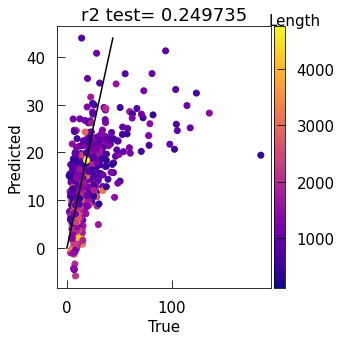

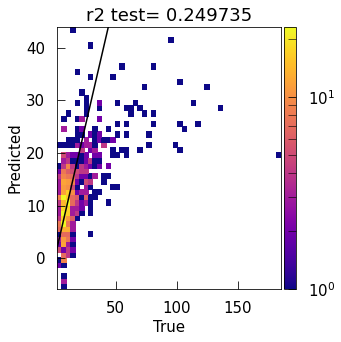

In [49]:
with torch.no_grad():  # To avoid memory allocation errors during runtime
    truth_vs_pred2(model_best_conv2d_bigger.to(device), get_data_image_2d_encoded(list(df.ORF), list(df.Cramer.astype('float')), 2048))